# LSTM-Solar-Production-ERCOT

The idea behind this project is to forecast when energy price spikes will occur in HB_NORTH and HB_WEST. By forecasting when energy energy price spikes occur we can enable battery companies in Texas to more efficiently perform energy arbitrage. 

### Value Proposition Of Project:

A battery in West Texas could charge at $25/MWh and sell at $800/MWh if it could somehow transport that electricity to North Texas (Dallas area) instantly (which it can't). But a battery strategically located between congested areas can capture these price differentials. The ML project predicts the price spread between West and North hubs, with a focus on daily patterns.
By forecasting a complex system where supply, demand, transmission constraints, and weather we can create profit opportunities.

### Scope:

I will focus exclusively on ERCOT's North and West load zones, using historical settlement point price data to build an LSTM model that predicts daily average price spreads between these regions. The model will identify arbitrage opportunities by forecasting when West Texas prices will be significantly lower than North Texas prices (>$50/MWh differential), enabling battery storage companies to optimize charge/discharge timing across geographic locations.


## 1. Importing and Cleaning Data:

In [2]:
import pandas as pd

hourly_ercot_dam_settlement_data = pd.read_csv(r"..\Data\filter_merged_ercot_data.csv")
print(hourly_ercot_dam_settlement_data.isna().sum())

# Let's reorganize our df so that we have separate columns for HB_NORTH and HB_WEST

'''
DeliveryDate,HourEnding,HB_NORTH,HB_WEST, SettlementPointPrice,DSTFlag

DeliveryDate | HourEnding | HB_NORTH | HB_WEST | price_spread | arbitrage_opportunity | DSTFlag
2022-01-01   | 1:00       | 45.20    | 25.50   | -19.70      | False                | N
2022-01-01   | 2:00       | 48.75    | 28.30   | -20.45      | False                | N
2022-01-01   | 3:00       | 42.10    | 22.80   | -19.30      | False                | N
2022-01-01   | 4:00       | 52.30    | 18.40   | -33.90      | True                 | N
2022-01-01   | 5:00       | 38.60    | 12.20   | -26.40      | True                 | N

['HB_NORTH'] needs to equal all the settlement price of HB_NORTH

'''

reshaped_data = hourly_ercot_dam_settlement_data.pivot_table(
    index=['DeliveryDate', 'HourEnding', 'DSTFlag'],
    columns='SettlementPoint',
    values='SettlementPointPrice'
).reset_index()

reshaped_data.columns.name = None
reshaped_data['price_spread'] = reshaped_data['HB_WEST'] - reshaped_data['HB_NORTH']

reshaped_data['west_cheaper_arbitrage'] = reshaped_data['price_spread'] < -25
reshaped_data['north_cheaper_arbitrage'] = reshaped_data['price_spread'] > 25
reshaped_data['arbitrage_opportunity'] = abs(reshaped_data['price_spread']) > 25 

final_data = reshaped_data[['DeliveryDate', 'HourEnding', 'HB_NORTH', 'HB_WEST', 'price_spread', 'arbitrage_opportunity','west_cheaper_arbitrage', 'north_cheaper_arbitrage','DSTFlag']]

print(final_data.isna().sum())
print(final_data.head())

Unnamed: 0              0
DeliveryDate            0
HourEnding              0
SettlementPoint         0
SettlementPointPrice    0
DSTFlag                 0
dtype: int64
DeliveryDate               0
HourEnding                 0
HB_NORTH                   0
HB_WEST                    0
price_spread               0
arbitrage_opportunity      0
west_cheaper_arbitrage     0
north_cheaper_arbitrage    0
DSTFlag                    0
dtype: int64
  DeliveryDate HourEnding  HB_NORTH  HB_WEST  price_spread  \
0   2022-01-02      01:00     26.63    23.46         -3.17   
1   2022-01-02      02:00     24.79    21.96         -2.83   
2   2022-01-02      03:00     23.85    21.93         -1.92   
3   2022-01-02      04:00     22.81    20.51         -2.30   
4   2022-01-02      05:00     23.59    20.43         -3.16   

   arbitrage_opportunity  west_cheaper_arbitrage  north_cheaper_arbitrage  \
0                  False                   False                    False   
1                  False      

## 2. Preliminary EDA:

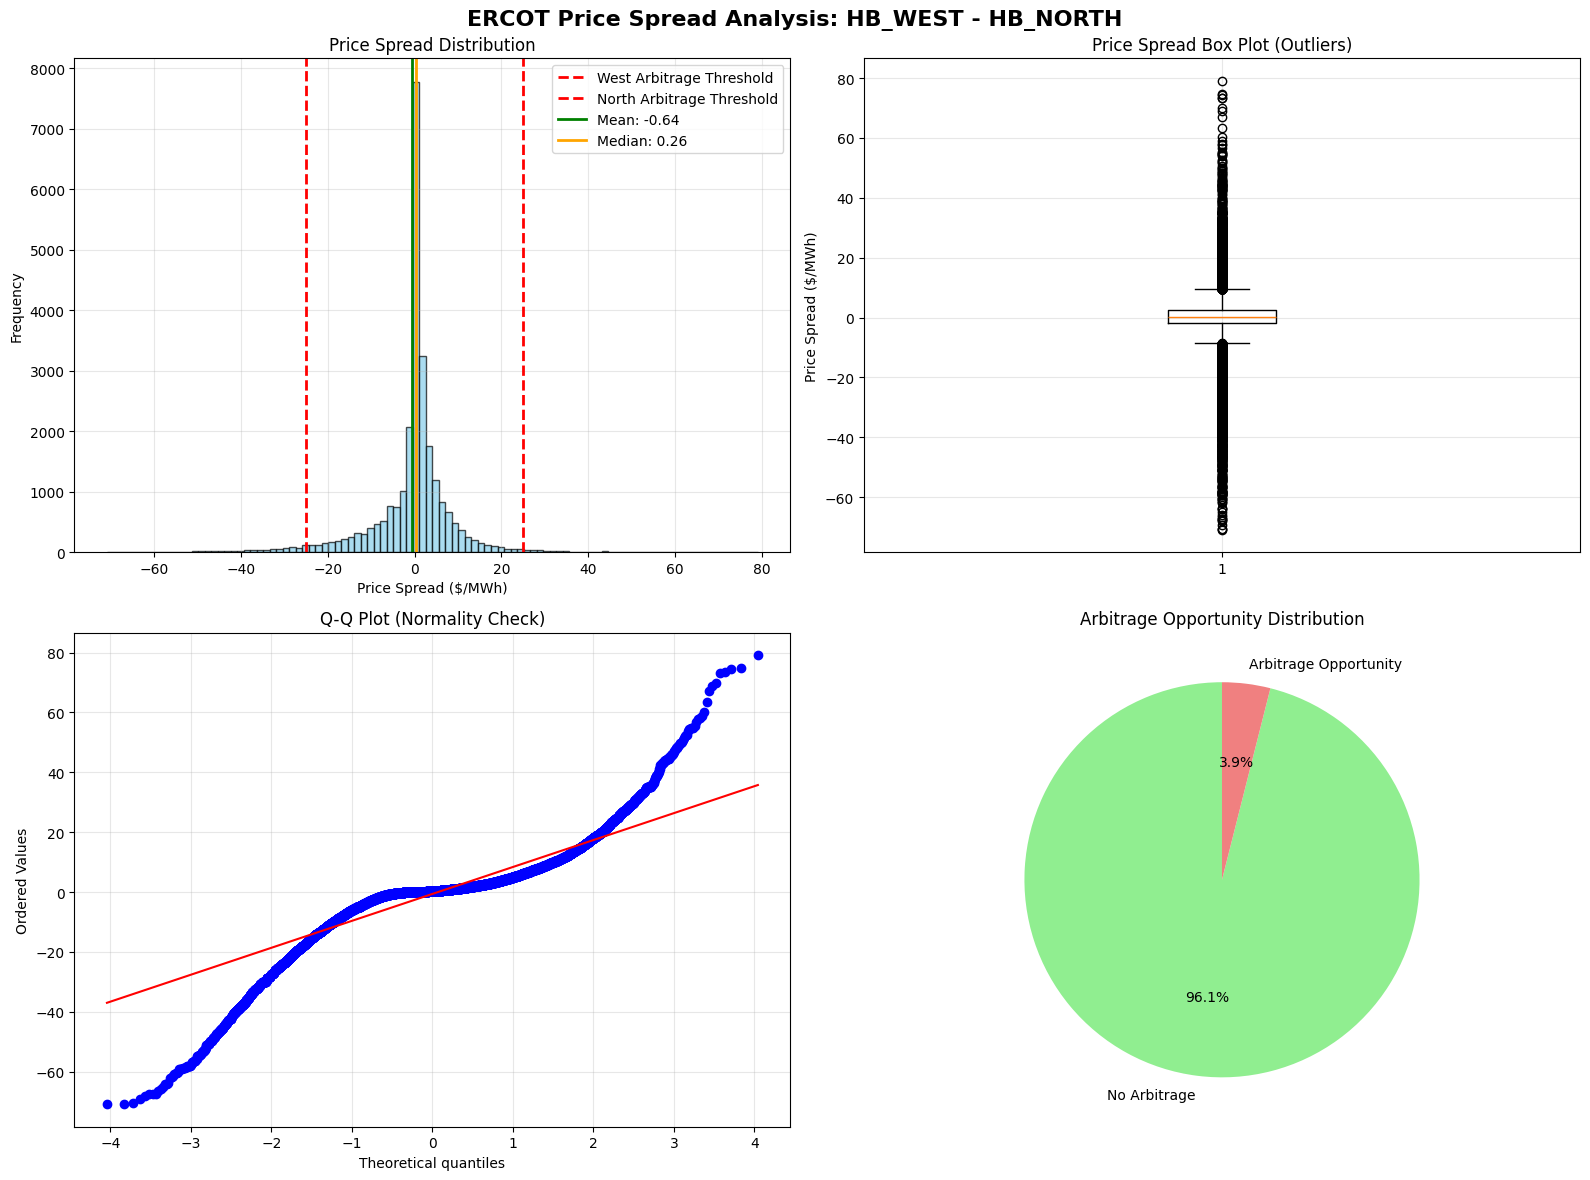

=== PRICE SPREAD SUMMARY STATISTICS ===
Mean: $-0.64/MWh
Median: $0.26/MWh
Std Dev: $9.95/MWh
Min: $-70.91/MWh
Max: $79.08/MWh
Skewness: -1.006
Kurtosis: 8.328

=== ARBITRAGE OPPORTUNITIES ===
Total observations: 26280
Arbitrage opportunities: 1036 (3.9%)
West cheaper opportunities: 759
North cheaper opportunities: 277


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('ERCOT Price Spread Analysis: HB_WEST - HB_NORTH', fontsize=16, fontweight='bold')


axes[0,0].hist(final_data['price_spread'], bins=100, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(-25, color='red', linestyle='--', linewidth=2, label='West Arbitrage Threshold')
axes[0,0].axvline(25, color='red', linestyle='--', linewidth=2, label='North Arbitrage Threshold')
axes[0,0].axvline(final_data['price_spread'].mean(), color='green', linestyle='-', linewidth=2, label=f'Mean: {final_data["price_spread"].mean():.2f}')
axes[0,0].axvline(final_data['price_spread'].median(), color='orange', linestyle='-', linewidth=2, label=f'Median: {final_data["price_spread"].median():.2f}')
axes[0,0].set_xlabel('Price Spread ($/MWh)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Price Spread Distribution')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)


axes[0,1].boxplot(final_data['price_spread'], vert=True)
axes[0,1].set_ylabel('Price Spread ($/MWh)')
axes[0,1].set_title('Price Spread Box Plot (Outliers)')
axes[0,1].grid(True, alpha=0.3)

stats.probplot(final_data['price_spread'], dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot (Normality Check)')
axes[1,0].grid(True, alpha=0.3)


arbitrage_counts = final_data['arbitrage_opportunity'].value_counts()
colors = ['lightcoral' if x else 'lightgreen' for x in arbitrage_counts.index]
axes[1,1].pie(arbitrage_counts.values, labels=['No Arbitrage', 'Arbitrage Opportunity'], 
              autopct='%1.1f%%', colors=colors, startangle=90)
axes[1,1].set_title('Arbitrage Opportunity Distribution')

plt.tight_layout()
plt.show()


print("=== PRICE SPREAD SUMMARY STATISTICS ===")
print(f"Mean: ${final_data['price_spread'].mean():.2f}/MWh")
print(f"Median: ${final_data['price_spread'].median():.2f}/MWh")
print(f"Std Dev: ${final_data['price_spread'].std():.2f}/MWh")
print(f"Min: ${final_data['price_spread'].min():.2f}/MWh")
print(f"Max: ${final_data['price_spread'].max():.2f}/MWh")
print(f"Skewness: {final_data['price_spread'].skew():.3f}")
print(f"Kurtosis: {final_data['price_spread'].kurtosis():.3f}")

print(f"\n=== ARBITRAGE OPPORTUNITIES ===")
print(f"Total observations: {len(final_data)}")
print(f"Arbitrage opportunities: {final_data['arbitrage_opportunity'].sum()} ({final_data['arbitrage_opportunity'].mean()*100:.1f}%)")
print(f"West cheaper opportunities: {final_data['west_cheaper_arbitrage'].sum()}")
print(f"North cheaper opportunities: {final_data['north_cheaper_arbitrage'].sum()}")